<a href="https://colab.research.google.com/github/sgmurphy00/TOOLS1/blob/google_collab_environment/ART_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Author: Paul Scheidt
# Description: Implement simple Machine Learning Classification Model for SAT6 Database
# Implement ART toolbox to perform poisoning attack

In [2]:
# Problem Definition


In [3]:
# Real-World Impact

In [4]:
# Dataset Description

In [5]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 18.9 MB/s eta 0:00:00


Quality of Data and Preprocessing

In [6]:
# Required Python Libraries
from google.colab import drive
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import time

# Libraries for CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from keras.layers import Dropout, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

# Libraries for Visualizing Deeplearning Models
from IPython import display
from tensorflow.keras.utils import plot_model
%matplotlib inline

In [7]:
# Initializing data, developing train/test splits
# Connecting to Deep Stat Database
drive.mount('/content/drive')




Mounted at /content/drive


In [8]:
DATA_PATH = '/content/drive/My Drive/DEEPSAT6/'
# Initializing training and valiadation Data Paths
train_data_path = DATA_PATH + '/X_train_sat6.csv'
train_label_path = DATA_PATH + 'y_train_sat6.csv'
test_data_path = DATA_PATH + 'X_test_sat6.csv'
test_label_path = DATA_PATH + 'y_test_sat6.csv'

# Storing data into pandas dataframes
x_train = pd.read_csv(train_data_path, header=None, dtype='uint8')
y_train = pd.read_csv(train_label_path, header=None, dtype='uint8')
x_test = pd.read_csv(test_data_path, header=None, dtype='uint8')
y_test = pd.read_csv(test_label_path, header=None, dtype='uint8')

# Investigating Shape of Pandas DataFrame
print("Train data shape: ", x_train.shape)
print("Train label shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test label shape: ", y_test.shape)

Train data shape:  (324000, 3136)
Train label shape:  (324000, 6)
Test data shape:  (81000, 3136)
Test label shape:  (81000, 6)


In [9]:
# Restructuring Training and Test Images to be 3 layers, RGB
x_train = x_train.values.reshape([-1,28,28,4])
x_test = x_test.values.reshape([-1,28,28,4])

x_train.shape, x_test.shape

((324000, 28, 28, 4), (81000, 28, 28, 4))

Text(0.5, 1.0, '0    0\n1    0\n2    0\n3    0\n4    0\n5    1\nName: 3, dtype: uint8')

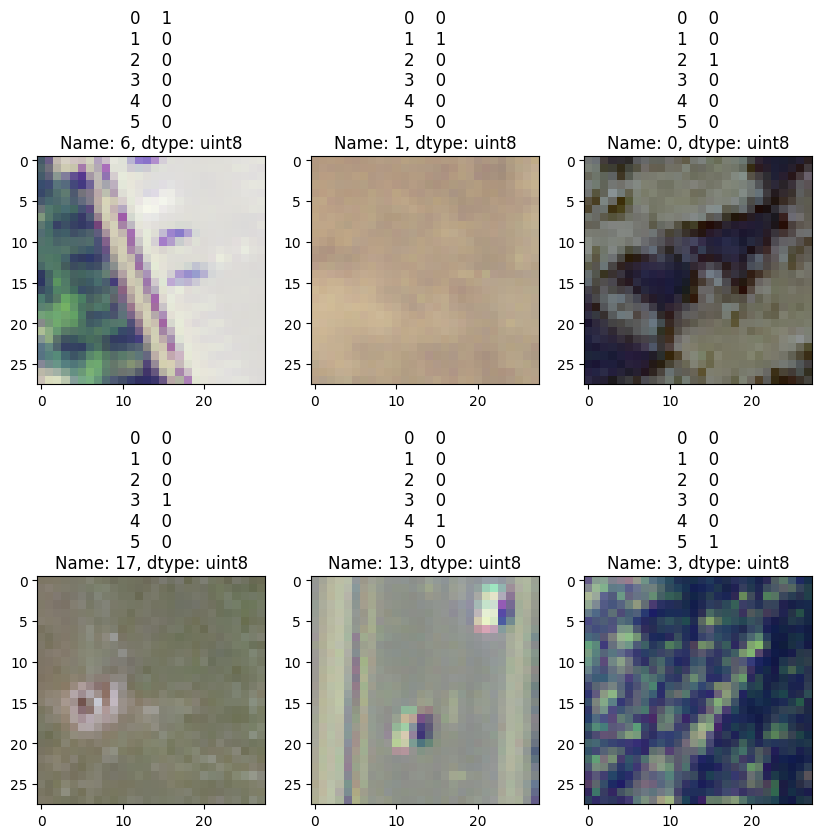

In [10]:
# This Code Block Highlights examples of images from each class


fig = plt.figure(figsize = (10,10))
rows = 2
cols = 3


# plotting Class A
ax1 = fig.add_subplot(rows, cols, 1)
img_A = x_train[6].reshape([28,28,4])[:,:,:3]
label_A = y_train.iloc[6]
plt.imshow(img_A)
ax1.set_title(label_A)

# Plotting Class B
ax2 = fig.add_subplot(rows, cols, 2)
img_B = x_train[1].reshape([28,28,4])[:,:,:3]
label_B = y_train.iloc[1]
plt.imshow(img_B)
ax2.set_title(label_B)

# plotting Class C
ax3 = fig.add_subplot(rows, cols, 3)
img_C = x_train[0].reshape([28,28,4])[:,:,:3]
label_C = y_train.iloc[0]
plt.imshow(img_C)
ax3.set_title(label_C)

# Plotting Class D
ax4 = fig.add_subplot(rows, cols, 4)
img_D = x_train[17].reshape([28,28,4])[:,:,:3]
label_D = y_train.iloc[17]
plt.imshow(img_D)
ax4.set_title(label_D)

# plotting Class E
ax5 = fig.add_subplot(rows, cols,5)
img_E = x_train[13].reshape([28,28,4])[:,:,:3]
label_E = y_train.iloc[13]
plt.imshow(img_E)
ax5.set_title(label_E)

# Plotting Class F
ax6 = fig.add_subplot(rows, cols, 6)
img_F = x_train[3].reshape([28,28,4])[:,:,:3]
label_F = y_train.iloc[3]
plt.imshow(img_F)
ax6.set_title(label_F)

In [11]:
# Insert Exploritory EDA

In [12]:
# Loading Pretrained Image Model

In [13]:
# Implementing Multi-Class, Classifier CNN in Tensor Flow
# Description: Implement traditional model, highlight model architecture, train and evaluate model performance

input = tf.keras.Input(shape=(28,28,4))
x = layers.Conv2D(filters=32,kernel_size=4,activation='relu')(input)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x= layers.Conv2D(filters=64,kernel_size=4,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128,activation='relu')(x)
output = layers.Dense(6,activation='softmax')(x)

model = tf.keras.Model(inputs=input,outputs=output)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 25, 25, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 9, 9, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 166,886 (651.90 KB)

 Trainable params: 166,886 (651.90 KB)

 Non-trainable params: 0 (0.00 B)

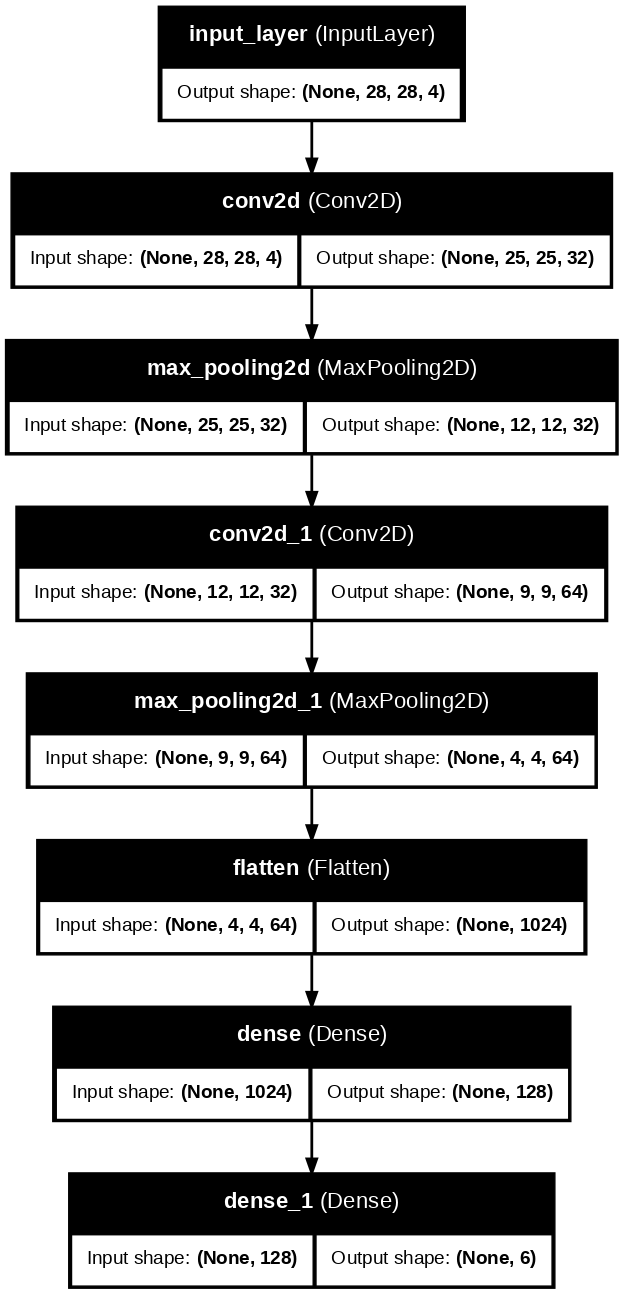

<Figure size 1000x1000 with 0 Axes>

In [14]:
# Displaying CNN Model
plt.figure(figsize=(10, 10))
plot_model(model, show_shapes=True, show_layer_names=True, dpi=100)


In [19]:
# Compiling Model

opt = RMSprop(learning_rate=0.001)  # Increasing learning rate

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=["accuracy"])

history_baseline_model = model.fit(
    x_train,
    y_train,
    epochs=30,
    batch_size=64,
    validation_data=(x_test,y_test))


Epoch 1/30
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7057 - loss: 1.3293 - val_accuracy: 0.7042 - val_loss: 0.7531
Epoch 2/30
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6983 - loss: 1.2757 - val_accuracy: 0.4947 - val_loss: 1.7702
Epoch 3/30
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6619 - loss: 1.6730 - val_accuracy: 0.7530 - val_loss: 0.6712
Epoch 4/30
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7237 - loss: 1.3773 - val_accuracy: 0.7309 - val_loss: 0.6774
Epoch 5/30
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7088 - loss: 2.1969 - val_accuracy: 0.6358 - val_loss: 0.9540
Epoch 6/30
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7096 - loss: 1.4820 - val_accuracy: 0.7504 - val_loss: 1.1237
Epoch 7/30
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7080 - loss: 1.0984 - val_accuracy: 0.7067 - val_loss: 0.7292
Epoch 8/30
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.6825 - loss: 1

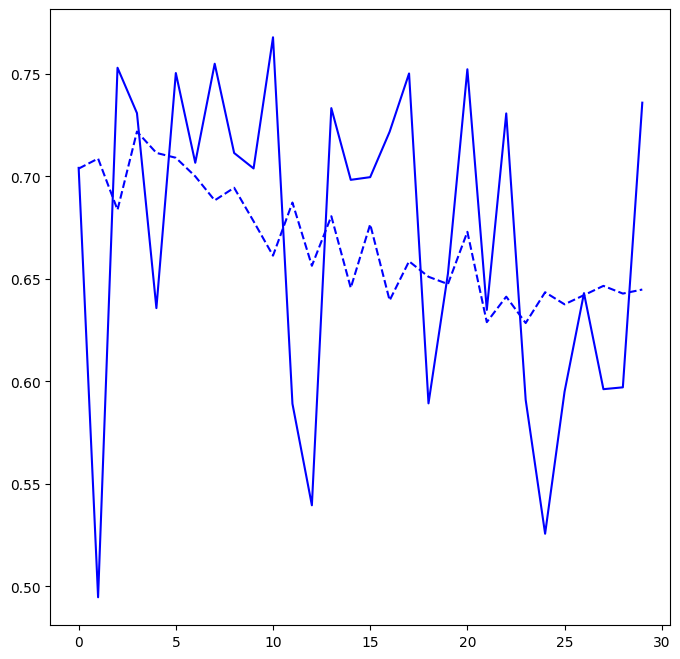

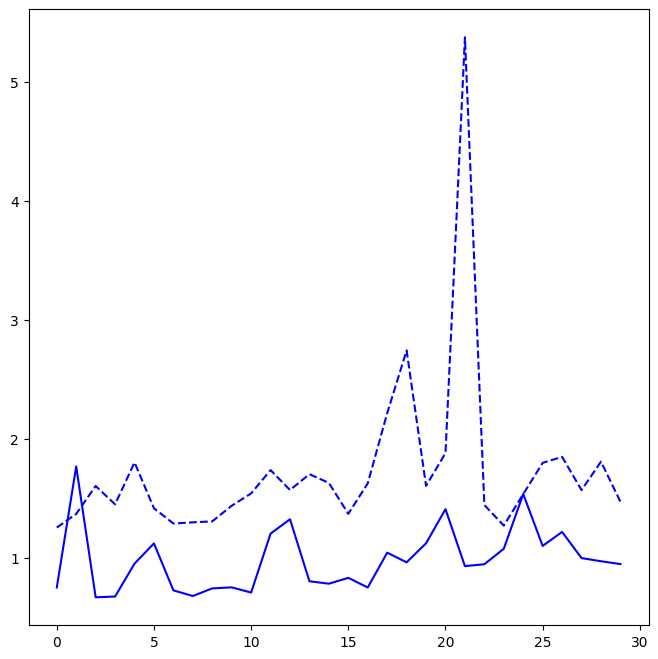

In [21]:
accuracy = plt.figure(figsize =(8, 8))

plt.plot(history_baseline_model.history['accuracy'],'b--',label='Baseline Model')
plt.plot(history_baseline_model.history['val_accuracy'],'b',label='Validation Data')
plt.show()

loss = plt.figure(figsize =(8, 8))
plt.plot(history_baseline_model.history['loss'],'b--',label='Training Data')
plt.plot(history_baseline_model.history['val_loss'],'b',label='Validation Data')
plt.show()